<a href="https://colab.research.google.com/github/MaxCojocari/CV_camp_projects/blob/main/chest_cancer_myver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp drive/MyDrive/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download --unzip -d mohamedhanyyy/chest-ctscan-images

 89% 105M/119M [00:01<00:00, 84.3MB/s] 
100% 119M/119M [00:01<00:00, 106MB/s] 


In [11]:
#Important imports
import torch
from torch import nn as nn
from torch.utils.data import DataLoader
from torch import optim 
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms,models
import matplotlib.pyplot as plt

#Choosing devide to be gpu if have one, else cpu
cuda_available = torch.cuda.is_available()

# If cuda is available we are going to use it
# otherwise we are going to train the model on the cpu
DEVICE = (
    torch.device('cuda')
    if cuda_available
    else torch.device('cpu')
)

print(f'We are going to train the model using {DEVICE}.')

We are going to train the model using cuda.


In [12]:
transformations = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [13]:
train_data = ImageFolder(r'/content/drive/MyDrive/Data_ML/Data/train', transform = transformations)
test_data = ImageFolder(r'/content/drive/MyDrive/Data_ML/Data/test', transform = transformations)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


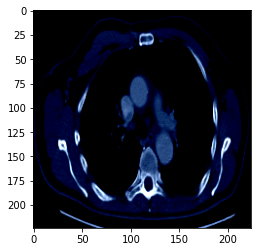

In [14]:
plt.imshow((train_data[1][0]).permute(1,2,0))

In [18]:
# Training loop for our network
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, test_loader, print_plot=True):

    #Initializing two lists to save accuracy to plot them later
    train_accuracy = torch.zeros(n_epochs)
    test_accuracy = torch.zeros(n_epochs)

    #Going thru every epoch
    for epoch in range(n_epochs):

        #Going thru example, thru every batch, in our case, thru all data at once
        for example, labels in train_loader:     

            #Translating calculations to gpu if is available
            example = example.to(DEVICE)
            labels = labels.to(DEVICE)

            # ensuring equal number of dimensions for labels and examples
            labels  = labels.unsqueeze(1)

            # running our data thru our data - forward
            output = model(example.float())
            # Getting loss of our network right now
            loss = loss_fn(output, labels.float())

            # Zeroing the gradient to not stack it from other iterations
            optimizer.zero_grad()
            #Runing backward part of the neural network, getting gradiets
            loss.backward()
            #Updating our paramters
            optimizer.step()
            
        # This with statement turns off auto grad
        with torch.no_grad():
            
            # This loop computes the accuracy for test and train data after each epoch
            for loader, accuracy in [(train_loader, train_accuracy),(test_loader, test_accuracy)]:
                correct = 0
                total = 0

                for examples, labels in loader:
                    examples = examples.to(device=DEVICE)
                    labels = labels.to(device=DEVICE).view(-1, 1)

                    outputs = model(examples.float())
                    predicted = torch.round(outputs)

                    total += labels.shape[0]
                    correct += (predicted == labels).sum()

                accuracy[epoch] = correct / total
                
        print(f'Epoch {epoch+1})', 
              f'Train Accuracy: {train_accuracy[epoch]}',
              f'Test Accuracy: {test_accuracy[epoch]}')

    #If set to True, print graph of train and validation loss
    if print_plot:

        #Setting x-ticks
        epochs = range(n_epochs)

        #Ploting both curves, train and val 
        plt.figure(dpi=150)
        plt.plot(epochs, train_accuracy, 'r', label='Training')
        plt.plot(epochs, test_accuracy, 'b', label='Test')
        plt.title('Training and Test accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

In [19]:
train_loader = DataLoader(train_data, batch_size = 64, shuffle=True)
test_loader = DataLoader(test_data, batch_size = 64, shuffle=True)

Epoch 1) Train Accuracy: 0.3230016231536865 Test Accuracy: 0.16825397312641144
Epoch 2) Train Accuracy: 0.3278956115245819 Test Accuracy: 0.1746031790971756
Epoch 3) Train Accuracy: 0.38172921538352966 Test Accuracy: 0.24444444477558136
Epoch 4) Train Accuracy: 0.34094616770744324 Test Accuracy: 0.2539682686328888
Epoch 5) Train Accuracy: 0.3768352270126343 Test Accuracy: 0.24444444477558136
Epoch 6) Train Accuracy: 0.4355628192424774 Test Accuracy: 0.32698413729667664
Epoch 7) Train Accuracy: 0.43882545828819275 Test Accuracy: 0.21904762089252472
Epoch 8) Train Accuracy: 0.4600326418876648 Test Accuracy: 0.31111112236976624
Epoch 9) Train Accuracy: 0.4600326418876648 Test Accuracy: 0.3047619163990021
Epoch 10) Train Accuracy: 0.48123979568481445 Test Accuracy: 0.32698413729667664


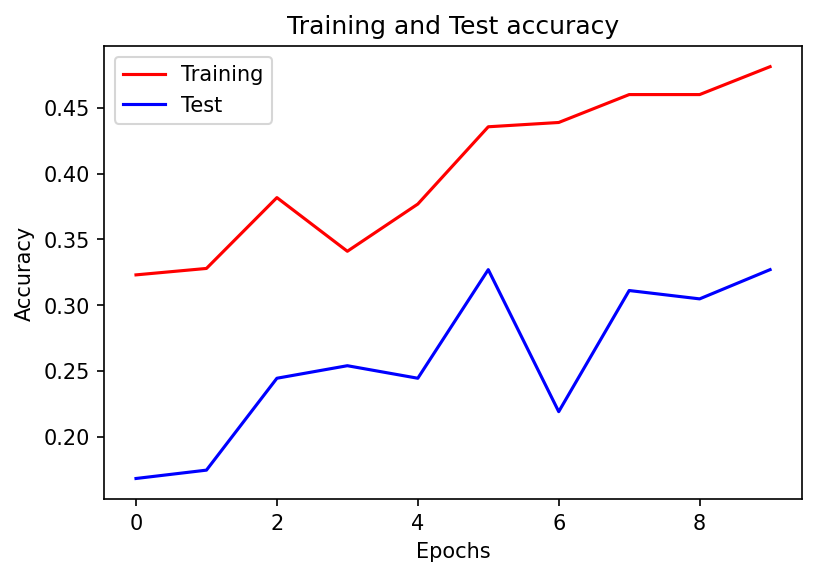

In [20]:
from collections import OrderedDict

model = models.resnet50(pretrained = True)

for param in model.parameters():
    param.required_grad = False
    
nr_feat = model.fc.in_features #2048
model.fc = nn.Sequential(OrderedDict([('fc',nn.Linear(nr_feat,1)),('sigmoid',nn.Sigmoid())]))

learning_rate = 1e-3
model = model.to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr = learning_rate)
loss_fn = nn.BCELoss()

#loss_fn = nn.BCEWithLogitsLoss()

training_loop(
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot = True,
    train_loader = train_loader,
    test_loader = test_loader
)